In [2]:
import numpy as np
import theano 
import theano.tensor as T


import IPython
import matplotlib.pyplot as plt
import timeit

%pylab inline
pylab.rcParams['figure.figsize'] = (6, 4)

%matplotlib inline
plt.rcParams['figure.figsize'] = (6.0, 5.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

Using gpu device 0: GeForce GTX 670MX (CNMeM is enabled with initial size: 10.0% of memory, cuDNN 5105)


Populating the interactive namespace from numpy and matplotlib


# Overfitting et régularisation 

Overfitting = surapprentissage 

Le modèle apprend "par coeur" les données d'entrainement. 
Il n'y a plus de généralisation. 

![Softmax function](../resources/overfitting_s.png )


Une technique pour résoudre ce problème : empécher les poids/paramètres d'être trop importants ! 

On ajoute un terme de régularisation à la fonction de coût : 

$$ E(X,Y,\theta) + \mu_{1} | \theta | + \mu_{2} || \theta ||^2 $$

In [ ]:
# Si W_1 et W_2 sont des variables correspondants aux paramètres du modèle 
L1 = abs(W_1).sum() + abs(W_2).sum() 
L2 = (W_1**2).sum() + (W_2**2).sum() 

cost = cost + mu_1*L1 + mu_2*L2

# Réseaux de neurones 

#### Objectif de cette partie construire un réseau de neurones pour classiffier des caractères manuscrits (Digit-Recognizer de Kaggle)

* nombre de classes (sortie du réseau) : 10
* entrée du réseau : 28x28 = 784 
* trois couches cachées (n_1, n_2, n_3)

# Données et paramètres d'apprentissage 

In [3]:
## Données d'entrainement, de validation et de test (labels inconnus)
X_train = np.load('../data/digit-recognizer/X_train.npy')
X_valid = np.load('../data/digit-recognizer/X_valid.npy')
X_test = np.load('../data/digit-recognizer/X_test.npy')

## Les labels 
Y_train = np.load('../data/digit-recognizer/y_train.npy')
Y_valid = np.load('../data/digit-recognizer/y_valid.npy')

print(X_train.shape, X_valid.shape, X_test.shape)
print(Y_train.shape, Y_valid.shape)

((37000, 784), (5000, 784), (28000, 784))
((37000,), (5000,))


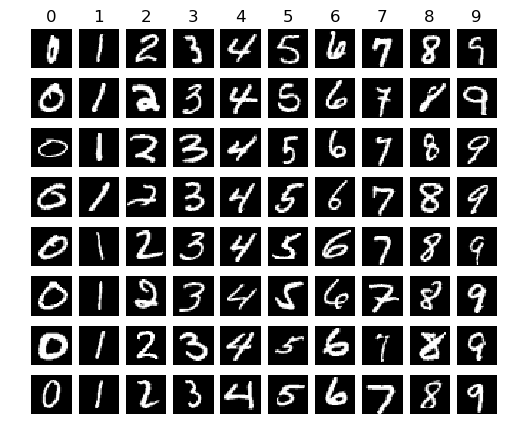

In [20]:
classes = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
num_classes = len(classes)
samples = 8

for y, cls in enumerate(classes):
    idxs = np.nonzero([i == y for i in Y_train])
    idxs = np.random.choice(idxs[0], samples, replace=False)
    for i , idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples, num_classes, plt_idx)
        plt.imshow(X_train[idx].reshape((28, 28)))
        plt.axis("off")
        if i == 0:
            plt.title(cls)
        

plt.show()

In [21]:
X_train_shared =  T.cast(theano.shared(X_train, borrow=True),'float32')
Y_train_shared = T.cast(theano.shared(Y_train, borrow=True),'int32')

In [40]:
learning_rate=0.01
n_epochs=100
batch_size=128

n_train_batches = X_train.shape[0] // batch_size

mu_1 = 0.0
mu_2 = 0.0005

# nb de pixels
n_in = 28*28

n_1 = 200
n_2 = 200
n_3 = 200

#nb de classes
n_out = 10

### Fonction d'activation 

In [41]:
# choix de la fonction d'activation : sigmoid, tanh, ReLU 
# T.nnet.sigmoid, T.nnet.ultra_fast_sigmoid, T.nnet.hard_sigmoid, T.tanh, T.nnet.relu ... 

activation = T.nnet.sigmoid

# pour initialiser les poids 
rng = np.random.RandomState(1234)

### Construction du modèle 

In [42]:
# Toujours besoin des 3 mêmes variables symboliques 

index = T.lscalar('index')
X = T.matrix('X')
Y = T.ivector('Y')



Cette fois les poids initiaux ne doivent pas être nuls ! 
On va utiliser : 



```
rng.uniform( low=-max_val
             high=max_val
             size=(n_in_layer, n_out_layer)),
             dtype=theano.config.floatX)
```

avec `max_val = np.sqrt(6. / 500)`

( ~  Xavier Initialization)



#### Première couche cachée 

On va créer deux variables `W_1` et `b_1` (les poids de cette couche).

On construit ensuite la sortie de cette couche : `output_1`

In [43]:
max_val = 0.0780

In [44]:
W_1 = theano.shared(value=np.asarray(
                                    rng.uniform( low=-max_val,
                                                 high=max_val,
                                                size=(n_in, n_1)),
                                    dtype=theano.config.floatX),
                    name='W_1', borrow=True)

        
b_1 = theano.shared(value=np.zeros((n_1,), dtype=theano.config.floatX), name='b_1', borrow=True)

output_1 = activation(T.dot(X, W_1) + b_1)

#### Deuxième et troisième couches 

In [45]:
W_2 = theano.shared(value=np.asarray(
                                    rng.uniform( low=-max_val,
                                                 high=max_val,
                                                size=(n_1, n_2)),
                                    dtype=theano.config.floatX),
                    name='W_2', borrow=True)

        
b_2 = theano.shared(value=np.zeros((n_2,), dtype=theano.config.floatX), name='b_2', borrow=True)

output_2 = activation(T.dot(output_1, W_2) + b_2)

In [46]:
W_3 = theano.shared(value=np.asarray(
                                    rng.uniform( low=-max_val,
                                                 high=max_val,
                                                size=(n_2, n_3)),
                                    dtype=theano.config.floatX),
                    name='W_3', borrow=True)

        
b_3 = theano.shared(value=np.zeros((n_3,), dtype=theano.config.floatX), name='b_3', borrow=True)

output_3 = activation(T.dot(output_2, W_3) + b_3)

#### On place une couche de régression logistique en sortie 

In [47]:
W_logReg = theano.shared(
            value=np.zeros(
                (n_3, n_out),
                dtype=theano.config.floatX
            ),
            name='W_logReg',
            borrow=True
        )
b_logReg = theano.shared(
            value=np.zeros(
                (n_out,),
                dtype=theano.config.floatX
            ),
            name='b_logReg',
            borrow=True
        )

#Sortie de la régression logistique 
p_y_given_x = T.nnet.softmax(T.dot(output_3, W_logReg) + b_logReg)

### Termes de régularisation 

In [48]:
params  = [W_1, b_1, W_2, b_2, W_3, b_3, W_logReg, b_logReg]
# Pensez à utiliser les "List Comprehensions"

L1 = sum([abs(param).sum() for param in params])
L2 = sum([(param**2).sum() for param in params])

In [49]:
# On définit les expressions pour les fonctions de coûts (on n'oublie pas les termes de régularisation),
# de prédiction et de taux d'erreur 

cost = -T.mean(T.log(p_y_given_x)[T.arange(Y.shape[0]), Y]) + mu_1*L1 + mu_2*L2

y_pred = T.argmax(p_y_given_x, axis=1)

errors = T.mean(T.neq(y_pred, Y))

### Compilation des expressions en fonctions 

In [50]:
validate_model = theano.function(
        inputs=[X,Y],
        outputs= errors
    )


test_model = theano.function(
        inputs=[X],
        outputs= y_pred
    )


In [51]:
# même remarque : List Comprehensions
params = [W_1, b_1, W_2, b_2, W_3, b_3, W_logReg, b_logReg]

gparams = [T.grad(cost, param) for param in params]

updates = [
        (param, param - learning_rate * gparam)
        for param, gparam in zip(params, gparams)
    ]

# cette fois on veut le taux d'erreur et le coût en sortie !
train_model = theano.function(
        inputs=[index],
        outputs=cost,
        updates=updates,
        givens={
            X: X_train_shared[index * batch_size: (index + 1) * batch_size],
            Y: Y_train_shared[index * batch_size: (index + 1) * batch_size]
        }
    )

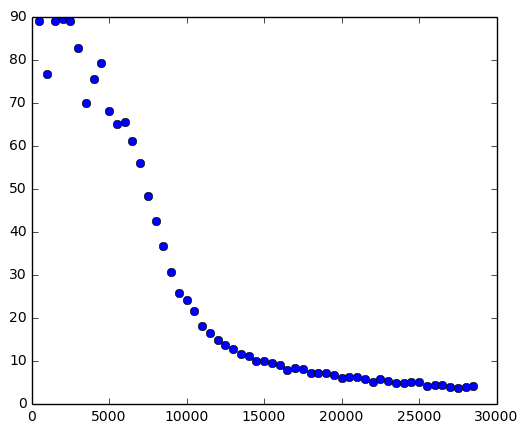

Entrainement fini : 390.000000 %
en 86 secondes, avec 1.147253 epochs/sec


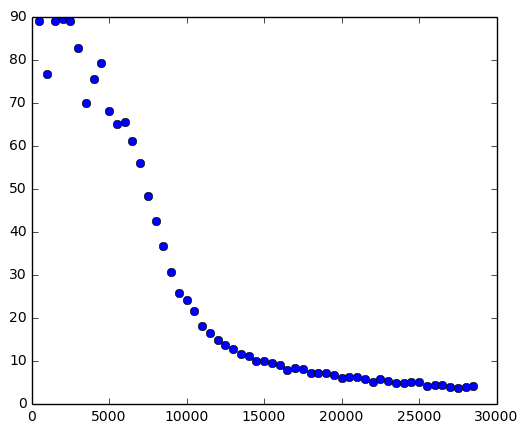

In [52]:
best_validation_loss = np.inf
validation_frequency = 500

start_time = timeit.default_timer()
for epoch in range(n_epochs):
    for minibatch_index in range(n_train_batches):
        
        minibatch_avg_cost = train_model(minibatch_index)
            
        # iteration number
        iter = (epoch) * n_train_batches + minibatch_index

        if (iter + 1) % validation_frequency == 0:
            this_validation_loss = validate_model(X_valid,Y_valid.astype('int32'))*100.

            pylab.plot([iter], [this_validation_loss], 'bo', label='validation_loss')
            IPython.display.clear_output(wait=True)
            IPython.display.display(pylab.gcf())
        
            
            if this_validation_loss < best_validation_loss:
                best_validation_loss = this_validation_loss

end_time = timeit.default_timer()

print(( 'Entrainement fini : %f %%') % (best_validation_loss * 100.))
    
print('en %d secondes, avec %f epochs/sec' % ((end_time - start_time), 1. * epoch / (end_time - start_time)))

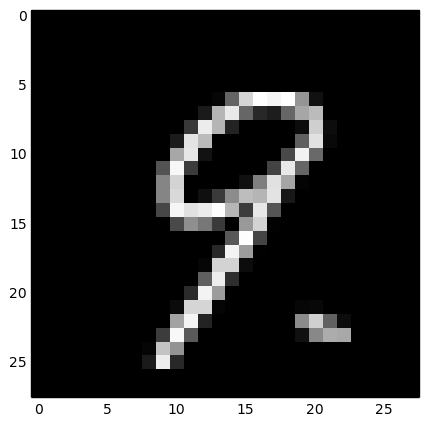

In [53]:
plt.imshow(X_test[2].reshape(28,28))

In [54]:
predictions = test_model(X_test)
predictions

array([2, 0, 9, ..., 3, 9, 2])

In [55]:
out_file = open("predictions-DIGIT-RECOGNIZER.csv", "w")
out_file.write("ImageId,Label\n")
for i in range(len(predictions)):
    out_file.write(str(i+1) + "," + str(int(predictions[i])) + "\n")
out_file.close()
    